# Automatic E-mail Categorization

The focus of this project is to classify e-mails into folders using the content of each e-mail.  How strong is the correlation between the words in an e-mail and the folder that a user places the e-mail?  To answer these questions, the processed data will be trained, tested and evaluated using several machine learning models.  

Undoubtedly, categorizing e-mails based on the content alone can pose so many challenges.  In reality, there is a constant stream of new information being passed through e-mails each day and much of what we learned through previous e-mails may not contain this new information.
Also, the content of e-mail threads can branch off onto new topics.  Users could also create mostly unused folders.  The problems go on, but you get the idea of the scope of this problem.  

Nonetheless, I found this to be an interesting angle to tackle the Enron Corpus, the largest public domain database in the world containing real-world email messages.  The version used contains over 500,000 emails from about 150 users, mostly senior management at Enron. You can visit [here](https://en.wikipedia.org/wiki/Enron_scandal) to learn more about the Enron scandal.  You can get a copy of the dataset [here](https://www.cs.cmu.edu/~./enron/).  

Benchmark results and for this project can be found [here](http://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1217&context=cs_faculty_pubs).  Bekkerman et al. (Ron Bekkerman, Andrew McCallum and Gary Huang). *Automatic Categorization of Email into Folders: Benchmark Experiments on Enron and SRI Corpora*

## 1. Exploring the Enron Emails Dataset

In [285]:
import pandas as pd
import numpy as np
from IPython.display import display
import email

filepath = "data/emails.csv"
# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)
#emails = emails.iloc[:10] # testing 
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
# Print column names
print(emails.columns)
# Store column headers 
headers = [header for header in emails.columns]
# Print the first 5 rows of the dataset
print(display(emails.head()))

Successfully loaded 517401 rows and 2 columns!
Index([u'file', u'message'], dtype='object')


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


None


Numpy and pandas were imported, then the csv file containing the e-mails was read into a dataframe called **`emails`**.  The reading may take a while due to the size of the file.  Next, the shape of the dataset, column names and a sample of five rows within the dataset were printed.  There are 517,401 rows and 2 columns.  

**`file`** - contains the original directory and filename of each email. The root level of this path is the employee (surname first followed by first name initial) to whom the emails belong. 

**`message`** - contains the email text

### A sample e-mail

Here is a sample of the standard e-mail found in the data.  It contains a list of headers and a message body.  Note that there is a header label called "Mime-Version", which signifies that the e-mails in this dataset are MIME formatted.  MIME stands for Multipurpose Internet Mail Extensions and virtually all human-written email is transmitted in MIME format.  Python has a built in [MIME handling package](https://docs.python.org/2/library/email.html) and this is what will be used to dissect the data needed out of each e-mail.

In [4]:
print(emails.loc[0]["message"])
print("From emails.loc[0]["file"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 
allen-p/_sent_mail/1.


## 2. Data Cleaning

Here are the list of things that needs to be performed on the data:
* Add new columns in the `emails` dataframe 
* Check for missing values
* Remove unwanted characters 

### Add new columns

To perform e-mail categorization by folder, we will need to split the values found in the "file" column to retrieve the employee name and directory.  The values will be added to the `emails` dataframe as new columns.  

In [5]:
print emails.columns

Index([u'file', u'message'], dtype='object')


In [286]:
def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

def add_columns(df, column, labels):
    new_data = {}
    for item in df[column]: 
        # Split string into tokens
        tokens = item.split('/')
            # Get employee name (eg."allen-p")
        for i in range(0, 2):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)
            # Get folder (eg."_sent_mail")         
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    return df
emails = add_columns(df = emails, column = "file", labels = ["employee", "folder"])

### Here is a summary of the new `emails` dataset containing all the new columns.  

In [73]:
print(emails.shape)
print(display(emails.head()))

(517401, 4)


,file,message,employee,folder
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,allen-p,_sent_mail
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,allen-p,_sent_mail
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,allen-p,_sent_mail
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,allen-p,_sent_mail
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,allen-p,_sent_mail


None


### Missing Values

The `emails` dataframe was checked for missing values.  In this case, there were no missing values.

In [74]:
# Check for null values
null_values = emails.isnull().values.any()
if null_values == False: 
    print "No NaN values"
else:
    print null_values

No NaN values


### Remove Non-Topical Folders that are end nodes

Non-topical folders refer to folders that hold e-mails regardless of content (inbox, sent, trash, drafts are just a few).  These will be removed because it is pretty hard to accurately train a classifier using them. Below, you will find a list of all the end node folders and the number of e-mails stored in each.  Notice that a large portion of e-mails are stored in the automatically created folders of an e-mail application, such as:
* all_documents
* discussion_threads
* sent
* deleted_items
* inbox
* sent_items
* notes_inbox
* _sent_mail
* calendar

Note also that there are a lot of e-mails that were stored in a bunch of user created folders.  These will be more relevant for our classification problem.  

In [287]:
folder_count = emails["folder"].value_counts()
print(folder_count[:20])

all_documents          128103
discussion_threads      58609
sent                    57653
deleted_items           51356
inbox                   44859
sent_items              37921
notes_inbox             36665
_sent_mail              30109
calendar                 6133
archiving                4477
_americas                4021
personal                 2577
attachments              2026
meetings                 1872
c                        1656
schedule_crawler         1398
chris_stokley            1252
logistics                1192
archive                  1179
tw_commercial_group      1159
Name: folder, dtype: int64


In [288]:
# Folders we can filter out
non_topical_folders = ["_sent_mail", "calendar", "all_documents", "discussion_threads",
                       "sent", "deleted_items", "inbox", "sent_items", "notes_inbox"]

# A new dataframe without non-topical folders
emails = emails.loc[~emails['folder'].isin(non_topical_folders)]
print(emails.head())
print("The filtered dataframe now contains {} rows.  This is a much reduced dataframe, but still a lot of data!").format(filtered_emails.shape[0])

                     file                                            message  \
1230  allen-p/contacts/1.  Message-ID: <15816310.1075855374294.JavaMail.e...   
1231  allen-p/contacts/2.  Message-ID: <6521706.1075855374316.JavaMail.ev...   
3026     allen-p/straw/1.  Message-ID: <12644875.1075855692817.JavaMail.e...   
3027     allen-p/straw/2.  Message-ID: <22208447.1075855692838.JavaMail.e...   
3028     allen-p/straw/3.  Message-ID: <31438311.1075855692860.JavaMail.e...   

     employee    folder  
1230  allen-p  contacts  
1231  allen-p  contacts  
3026  allen-p     straw  
3027  allen-p     straw  
3028  allen-p     straw  
The filtered dataframe now contains 65993 rows.  This is a much reduced dataframe, but still a lot of data!


### Remove folders that contain just one e-mail

We also remove folders that contain one e-mail because such folders would not be significant for training our models later on.  Also, we can also infer that such folders were unused.

In [289]:
email_count = emails["folder"].value_counts()
email_count = dict(email_count)
small_folders = [key for key, val in email_count.items() if val < 2]
emails = emails.loc[~emails['folder'].isin(small_folders)]
print("Folders with less than 2 e-mails removed!")

Folders with less than 2 e-mails removed!


In [310]:
# dataframe containing counts of every word in the emails dataframe
email_count = emails["folder"].value_counts()
indices = email_count.index
#email_count = [float(i)/sum(email_count) for i in email_count]
count = pd.DataFrame(email_count, columns = ["folder"])
count.rename
count["Folder Names"] = indices
print count.head()

             folder Folder Names
archiving      4477    archiving
_americas      4021    _americas
personal       2577     personal
attachments    2026  attachments
meetings       1872     meetings


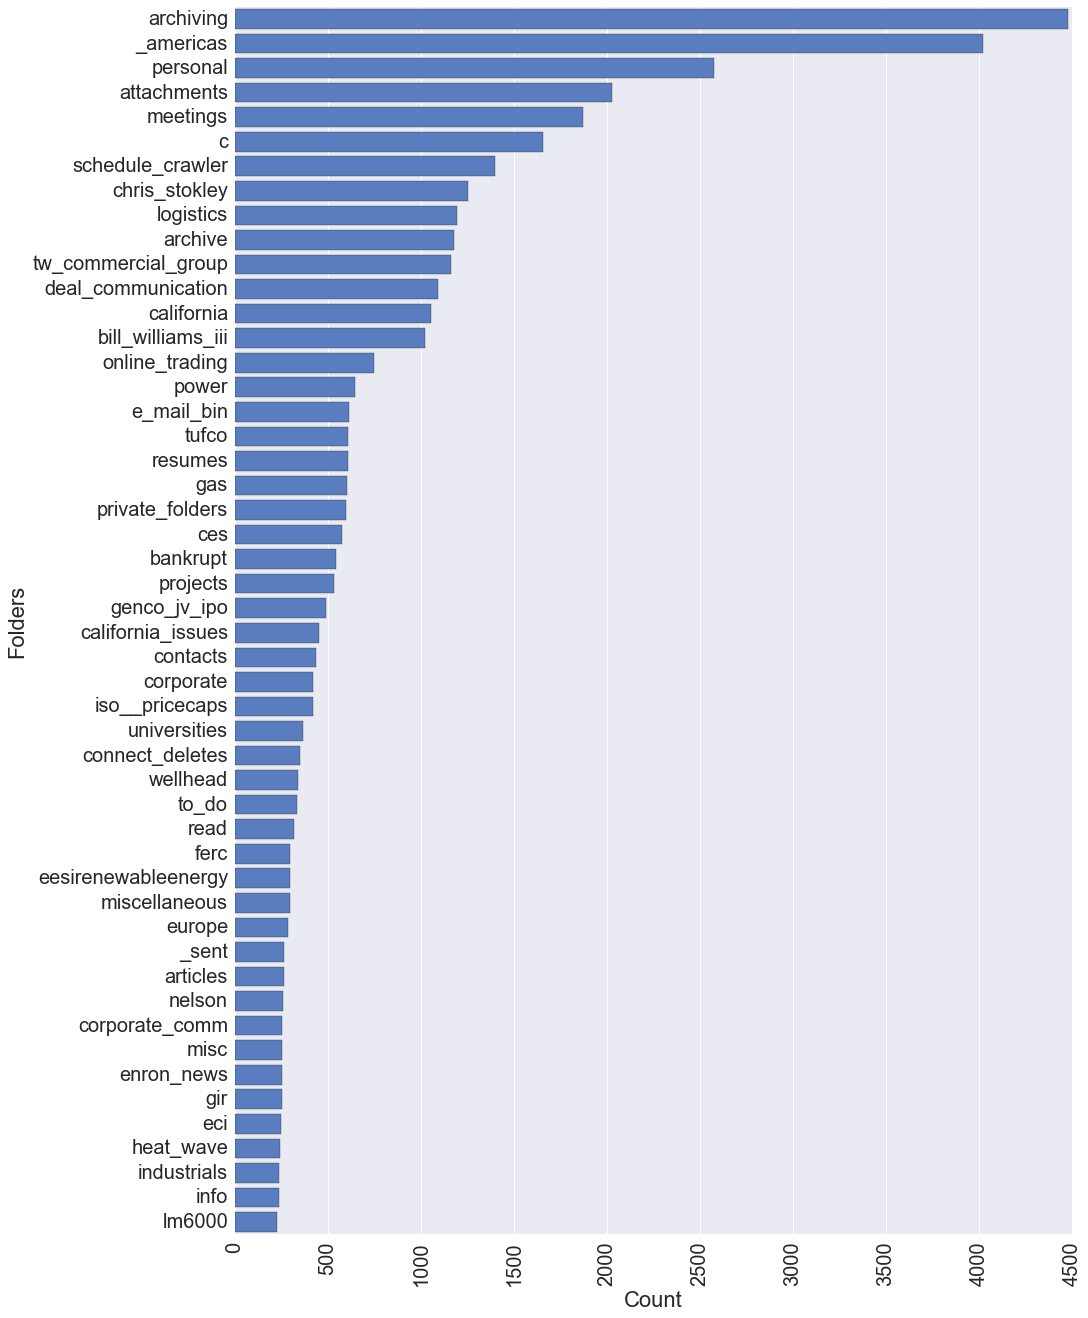

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 22))

# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(x = "folder", y = "Folder Names", data = count[:50], color = 'b', orient = "h")

# Plot the crashes where alcohol was involved

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Folders",
       xlabel="Count")
sns.set(font_scale=2)
plt.xticks(rotation=90) 
sns.plt.show()

**Figure 1**: Bar plot showing 35 folders that contain the most e-mails 

### Introducing the Bag-of-words model

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it.  One way to do this is by using something called a [**Bag-of-words model**](https://en.wikipedia.org/wiki/Bag-of-words_model).  It will take the e-mails as a string and convert it into a numerical vector to show the frequency that each unique word appears over the entire dataset.  The first step in creating a Bag-of-words model is called tokenization.  By tokenizing each e-mail, each string is split into a list of words. 

### Tokenization

In this step, the MIME handling python package mentioned earlier was used to extract both the headers and the messages found within each e-mail.  The data found within the headers section of each e-mail will be added to the `emails` dataframe as new features.  They are stored in the `header_data` dictionary.  All tokens are stored in `tokenized_messages` for further processing.

**Why lowercase the message body?**

Because a human may know that "Forecast" and "forecast" means the same thing, but the computer does not know this.  Also, while building the matrix using the bag-of-words model, lowercasing also reduces the chance of the same word being duplicated and entered as a separate word.

In [ ]:
# Returns a list of tokens
def tokenize(df, column):
    tokenized_messages = []
    for item in df[column]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        # lower case messages
        message_body = message_body.lower()
        # split message into tokens
        tokens = message_body.split(" ")
        tokenized_messages.append(tokens)
    return tokenized_messages

#tokenized_messages = tokenize(emails, "message")

# Returns a list of tokens
def get_messages(df, column):
    messages = []
    for item in df[column]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        # lower case messages
        message_body = message_body.lower()
        # split message into tokens
        #tokens = message_body.split(" ")
        messages.append(message_body)
    return messages

messages = get_messages(emails, "message")
print messages

###  Remove unwanted HTML Markup, punctuations and emoticons

In [239]:
unwanted_characters = [",", ":", ";", ".", "'", '"', "’", "?", "/", "-", "+", "&", 
                       "<", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", ">", "@", 
                       "(", ")", '\\', "~", "{", "}", "*", "^", "!", "\n"]

import re
def remove_special_chars(data):
    cleaned_tokenized_emails = []
    for item in tokenized_messages:
        tokens = []
        for token in item:
            text = re.sub(r'\W', "", token)
            tokens.append(text)
        cleaned_tokenized_emails.append(tokens)
    return cleaned_tokenized_emails

def remove_special_chars2(data):
    cleaned_msg = []
    for item in data:
        text = re.sub(r'\W', " ", item)
        cleaned_msg.append(text)
    return cleaned_msg
cleaned_msg = remove_special_chars2(messages)

In [ ]:
print cleaned_msg

## 3. Construct a Bag-of-words model

### Count words

Now that the data has been cleaned, it is time to construct a bag-of-words model to get the word counts.  Scikit-learn has a `CountVectorizer` class that is able to do just that.  It takes in a list of strings, in our case words, and outputs a dictionary mapping words as keys to their respective integer indices.  

In [240]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
docs = np.array(cleaned_msg)
bag = count.fit_transform(docs)
#print(count.vocabulary_)
vocab = count.vocabulary_

Here we convert the dictionary to a feature vector, where each index position corresponds to the values found in the CountVectorizer vocabulary.  

In [241]:
#print vocab
bag = bag.toarray()
print(bag[0][1076])
print len(bag[0])
print(bag[1])
print ""
print(bag[2])

1
2694
[0 0 0 ..., 0 0 0]

[0 0 0 ..., 0 0 0]


### Word Relevance using term frequency-inverse document frequency

Apply the Term frequency-inverse document frequency (tf-df) to downweight words that appear frequently in the e-mails but do not contain useful information.  Sci-kit learn has a transformer called the `TfidTransformer` to do this.  The `TfidTransformer` also normalizes the tf-idfs using L2-normalization.  Using L2-normalization helps to penalize the weight of the tf-dfs and prevent overfitting

In [242]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
bag = tfidf.fit_transform(count.fit_transform(docs)).toarray()

### Visualizing most relevant words

In [155]:
frequency = []
keys = []

for key, value in vocab.items():
    tally = bag[0][value]
    frequency.append(tally)
    keys.append(key)

words = pd.DataFrame(data = frequency, index = keys, columns = ["frequency"])
print(words.head(5))

                          frequency
capscopyright          9.368033e-07
chudson                8.431230e-06
cancelledthankssandra  9.368033e-07
imageimagecompaq       1.873607e-06
tradesten              4.684017e-07
